# Logistics Regression from Scratch

Here, we'll be implementing logistic regression, which is a classification algorithm using sigmoid function on the Titanic Survivors Dataset.

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy

## Importing Dataset

We'll import the dataset and split training and testing data.
We drop some columns cause - 
 - PassengerId is just Index and has no realtion to survival
 - Similarly Name and Ticket have no relation to survival as well
 - Cabin column has too many missing values to be reliable

In [30]:
data_train = pd.read_csv('Titanic_train.csv')

x = data_train.drop(columns=['Survived', 'PassengerId', 'Name', 'Cabin', 'Ticket'])
y = data_train['Survived'].to_numpy()

x.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S


## Data Preprocessiong

The data provided on the Titanic Dataset cannot be directly used for logistic regressio since it contians many string and floating values which are needed to be converted first.

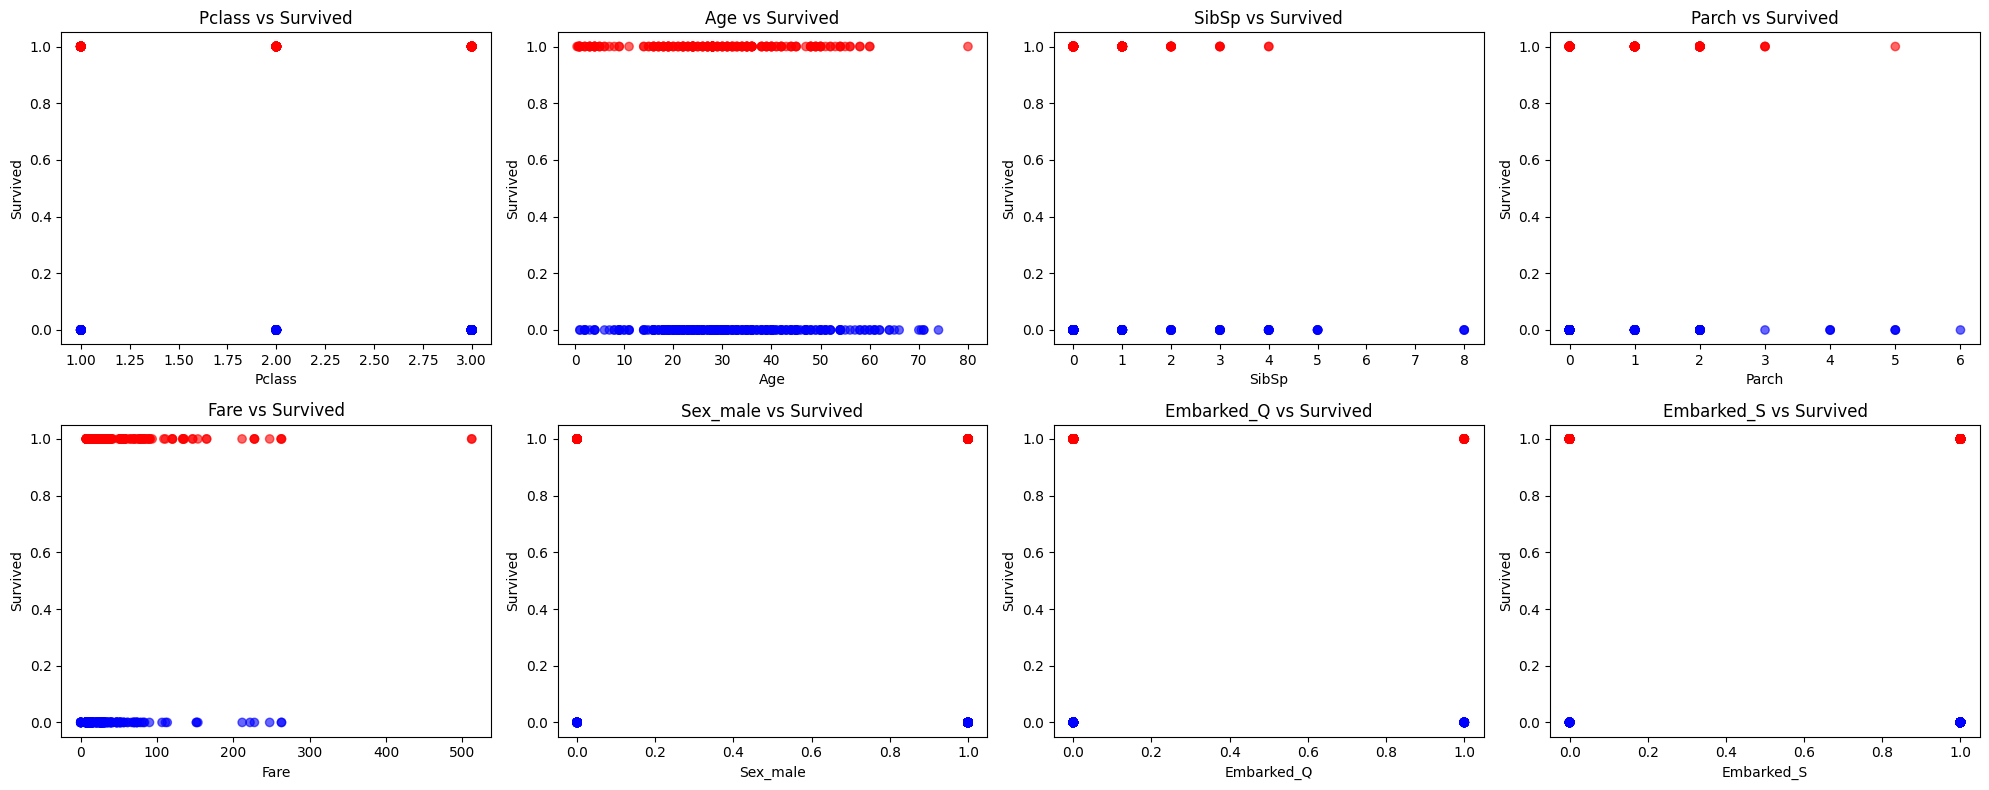

In [31]:
# Filing NaN values
x['Age'] = x['Age'].fillna(x['Age'].median())
x['Embarked'] = x['Embarked'].fillna(x['Embarked'].mode())

# Convert Categorical Strign values like sex and embarked to numerical format using one-hot encoding
x = pd.get_dummies(x, columns=['Sex', 'Embarked'], drop_first=True, dtype=int)

x_df = x

x = x.to_numpy()

#Splitting into test and train
shuffled_indices = np.random.permutation(x.shape[0])
n_test_samples = int(x.shape[0] * 0.25)

test_indices = shuffled_indices[:n_test_samples]
train_indices = shuffled_indices[n_test_samples:]

x_train = x[train_indices]
y_train = y[train_indices]
x_test = x[test_indices]
y_test = y[test_indices]

n_features = x_train.shape[1]
n_cols = 4
n_rows = (n_features + n_cols - 1) // n_cols

plt.figure(figsize=(5*n_cols, 4*n_rows))

for i, col in enumerate(x_df.columns):   # use names from DataFrame x
    plt.subplot(n_rows, n_cols, i+1)
    # color points by y=0 or y=1 for clarity
    plt.scatter(x_train[:, i], y_train, c=y_train, cmap='bwr', alpha=0.6)
    plt.xlabel(col)
    plt.ylabel("Survived")
    plt.title(f"{col} vs Survived")

plt.tight_layout()
plt.show()



## Feature Scaling

For the model to perform better, we shall implement feature scaling.

In [32]:
def zscore_normalize(x):
    mean = np.mean(x, axis=0)
    sigma = np.std(x, axis=0)
    x_norm = (x - mean) / sigma

    return x_norm, mean, sigma

x_train = zscore_normalize(x_train)[0]

## Sigmoid Function

We'll now define the sigmoid function which we'll use for logistic regression.

In [33]:
def sigmoid(z):
    g = 1/(1+np.exp(-z))

    return g

## Cross-Entropy Loss Function

We'll now implement cross-entropy loss function since it is best suited for classification.

In [34]:
def cross_entropy_loss(x, y, w, b):
    m = x.shape[0]

    cost = 0
    for i in range(m):
        z = np.dot(w, x[i]) + b
        f_x = sigmoid(z)
        cost += -y[i]*np.log(f_x) - (1-y[i])*np.log(1-f_x)
    
    cost = cost/m
    return cost

## Gradient Descent

We'll implement gradient descent for our logisitic regression model.

In [35]:
def compute_gradient_descent(x, y, w, b):
    m, n = x.shape
    dj_dw = np.zeros(n,)
    dj_db = 0

    for i in range(m):
        f_x = sigmoid(np.dot(x[i], w) + b)
        err = f_x - y[i]
        for j in range(n):
            dj_dw[j] += err * x[i, j]
        dj_db += err
    
    dj_dw = dj_dw/m
    dj_db = dj_db/m

    return dj_db, dj_dw

def graident_descent(x, y, w_in, b_in, alpha, n_iters):
    w = copy.deepcopy(w_in)
    b = b_in
    J_history = []

    for i in range(n_iters):

        dj_db, dj_dw = compute_gradient_descent(x, y, w, b)

        w -= alpha * dj_dw
        b -= alpha * dj_db

        if i<100000:
            J_history.append(cross_entropy_loss(x, y, w, b))
        
        if (i%(n_iters/10)) == 0:
            print(f"Iteration: {i+1}, Cost: {J_history[-1]}")
        
    return w, b, J_history

## Training the Model

Let's Train out model on Titanic dataset.

In [36]:
w_in = np.zeros(x_train.shape[1])
b_in = 0

alpha = 1
iters = 100

w, b, J_history = graident_descent(x_train, y_train, w_in, b_in, alpha, iters)

print(w, b)

Iteration: 1, Cost: 0.5885308991498471
Iteration: 11, Cost: 0.4531870038516435
Iteration: 21, Cost: 0.44405599335856855
Iteration: 31, Cost: 0.44197007585135845
Iteration: 41, Cost: 0.44132041823289414
Iteration: 51, Cost: 0.4410954941690202
Iteration: 61, Cost: 0.4410146050677395
Iteration: 71, Cost: 0.4409850817157878
Iteration: 81, Cost: 0.4409742369439826
Iteration: 91, Cost: 0.4409702410899002
[-1.04111448 -0.59624068 -0.3076641  -0.02021185  0.00439525 -1.25715588
 -0.06507549 -0.25705259] -0.7526450170363577


## Plotting Cost vs iter

Plotting a graph of cost function vs iterations

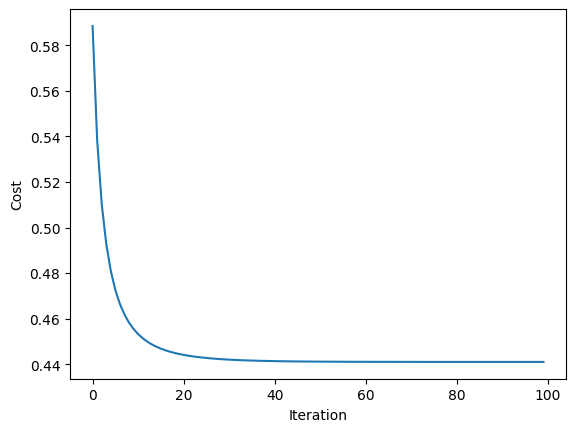

In [37]:
plt.plot(np.arange(len(J_history)), J_history)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

## Evaluating

Evaluating on a training set

In [38]:
def evaluate(x, y, w, b):

    f_x = sigmoid(np.dot(x, w) + b)

    accuracy = 0
    m = f_x.shape[0]

    for i in range(m):
        if f_x[i] >= 0.5 and y[i] == 1 :
            accuracy+=1
        if f_x[i] < 0.5 and y[i] == 0:
            accuracy+=1
    
    accuracy = accuracy / m

    return accuracy

print(evaluate(x_test, y_test, w, b))

0.5720720720720721


### Conclusion
So we can see that our model apporaches an accuracy of 0.57 wheras the scikit-learn model was able to achieve an accuracy of 0.82. Thus the model of Sklearn was much better